## Importing Relevant Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import PIL.Image as image
import pathlib
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

In [2]:
photo_dir='./celeb_photos'

In [3]:
photo_dir=pathlib.Path(photo_dir)
photo_dir

WindowsPath('celeb_photos')

In [4]:
phs=list(photo_dir.glob('*/*'))

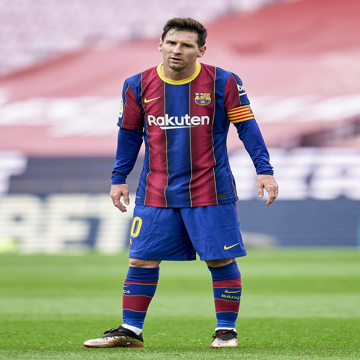

In [5]:
image.open(str(phs[90])).resize((360,360))

## Creating dictionaries for the images and their labels

In [6]:
images_dict={
    'messi':list(photo_dir.glob('messi/*')),
    'kohli':list(photo_dir.glob('virat_kohli/*')),
    'ronaldo':list(photo_dir.glob('ronaldo/*')),
    'vettel':list(photo_dir.glob('vettel/*')),
    'PV Sindhu':list(photo_dir.glob('pv_sindhu/*')),
}

In [7]:
photo_labels={
    'messi':0,
    'kohli':1,
    'ronaldo':2,
    'vettel':3,
    'PV Sindhu':4,
}

## Splitting data intoTrain and Test

In [8]:
x,y=[],[]

for celeb_name,celeb_images in images_dict.items():
    for img in celeb_images:
        image=cv2.imread(str(img))
        try:
            resized=cv2.resize(image,(360,360))
        except:
            continue
        x.append(resized)
        y.append(photo_labels[celeb_name])

In [9]:
x=np.array(x)
y=np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [11]:
x_train_scaled=x_train/255.0
x_test_scaled=x_test/255.0

In [12]:
x_train.shape

(357, 360, 360, 3)

In [13]:
y_train.shape

(357,)

## Using Transfer learning to train the model

In [14]:
feature_vector="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [15]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(360,360,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

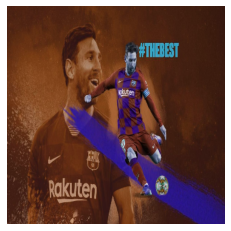

In [16]:
plt.imshow(x[0])
plt.axis('off')
plt.show()

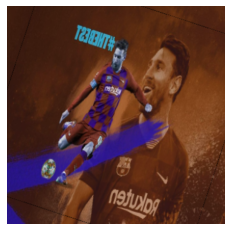

In [17]:
plt.imshow(data_augmentation(x)[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

In [18]:
resnet=tf.keras.Sequential([
    data_augmentation,
    hub.KerasLayer(feature_vector,input_shape=(360,360,3),trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5)
])

In [19]:
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 360, 360, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
resnet.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

In [21]:
resnet.fit(x_train_scaled,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 57s 6s/step - loss: 1.9857 - acc: 0.1825 - val_loss: 1.5533 - val_acc: 0.3194
Epoch 2/10
9/9 [==============================] - 61s 7s/step - loss: 1.5894 - acc: 0.3684 - val_loss: 1.2923 - val_acc: 0.5556
Epoch 3/10
9/9 [==============================] - 56s 6s/step - loss: 1.4294 - acc: 0.4070 - val_loss: 1.1853 - val_acc: 0.5556
Epoch 4/10
9/9 [==============================] - 60s 7s/step - loss: 1.2005 - acc: 0.5263 - val_loss: 0.9919 - val_acc: 0.7222
Epoch 5/10
9/9 [==============================] - 53s 6s/step - loss: 1.0060 - acc: 0.6140 - val_loss: 0.9104 - val_acc: 0.7083
Epoch 6/10
9/9 [==============================] - 55s 6s/step - loss: 0.9596 - acc: 0.6316 - val_loss: 0.8543 - val_acc: 0.7361
Epoch 7/10
9/9 [==============================] - 56s 6s/step - loss: 0.7656 - acc: 0.7298 - val_loss: 0.7878 - val_acc: 0.7639
Epoch 8/10
9/9 [==============================] - 57s 6s/step - loss: 0.8761 - acc: 0.6737 - val_loss: 0

In [22]:
resnet.evaluate(x_test_scaled,y_test)

4/4 [==============================] - 14s 4s/step - loss: 0.8008 - acc: 0.7311


[0.8007680177688599, 0.7310924530029297]

## Predictions

In [23]:
preds=resnet.predict(x_test_scaled)

In [24]:
preds

array([[-1.0910325 , -1.599033  ,  0.61287516, -0.6751471 , -1.4477688 ],
       [ 0.52352315, -1.4084687 , -0.8599992 , -2.356756  , -2.101537  ],
       [-2.512923  , -2.1092486 , -1.5483979 ,  1.4845406 , -1.9832265 ],
       [-1.9354287 , -1.4607377 , -1.2538962 ,  1.9038253 , -2.7565794 ],
       [-5.513174  , -1.8377094 , -1.7554883 , -0.19069965, -1.1242577 ],
       [-2.0773404 , -1.6652452 , -1.5992175 , -2.2638788 ,  0.2285315 ],
       [-0.3533147 , -1.0975988 , -1.2267902 , -1.2830107 , -1.2301388 ],
       [-0.705076  , -3.1968784 , -1.8090345 ,  0.3037505 , -3.333569  ],
       [ 0.22033407, -1.5545651 , -0.40698704, -2.2518818 , -2.2484102 ],
       [-2.1770465 , -4.300525  , -1.6689829 , -2.605185  ,  1.104081  ],
       [-1.1066215 , -1.1957335 , -1.5564139 , -1.1957539 , -3.5562487 ],
       [-0.87540907, -2.116705  ,  0.38956088, -0.71826816, -2.7201333 ],
       [-2.6992662 , -1.7419555 , -1.7886626 ,  0.36792967, -0.4843637 ],
       [-2.9187899 , -3.0881279 , -1.0

In [25]:
y_pred=[np.argmax(i) for i in preds]

In [26]:
classes=['messi','kohli','ronaldo','vettel','sindhu']

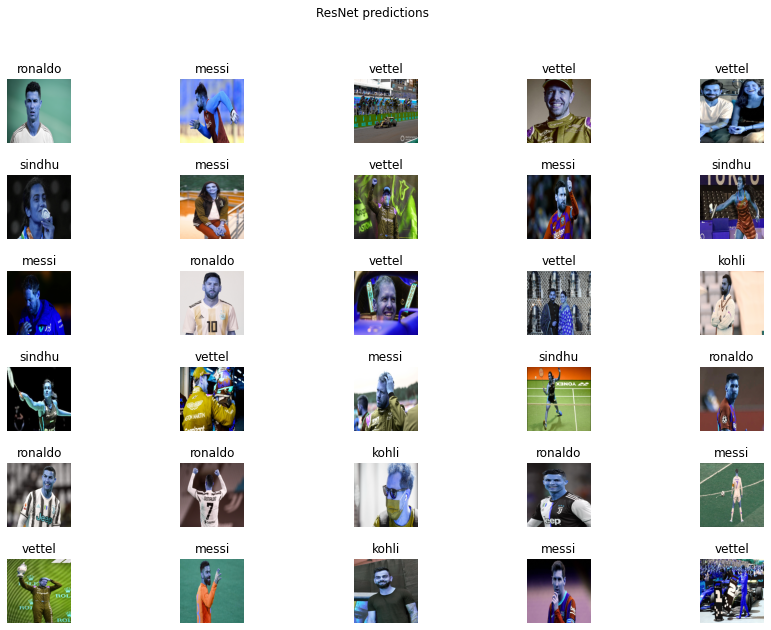

In [27]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(x_test_scaled[n])
    plt.title(classes[y_pred[n]])
    plt.axis('off')
    plt.suptitle("ResNet predictions")

## Confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

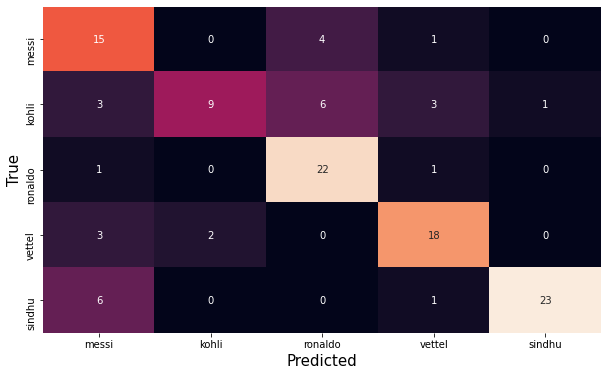

In [29]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,xticklabels=classes,yticklabels=classes,cbar=False)
plt.xlabel('Predicted', size=15)
plt.ylabel('True', size=15)
plt.show()

## Classification Report

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        20
           1       0.82      0.41      0.55        22
           2       0.69      0.92      0.79        24
           3       0.75      0.78      0.77        23
           4       0.96      0.77      0.85        30

    accuracy                           0.73       119
   macro avg       0.75      0.73      0.71       119
weighted avg       0.77      0.73      0.73       119

